In [1]:
from skimage import measure
import numpy as np
import pandas as pd
from PIL import Image
import json
import re
import glob
import cv2
import os
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from pathlib import Path
import shutil
import random

In [9]:
def filter_optimam_csv(csv_path, csv_out_path):
    """
    Filter the Optimam CSV file to only include relevant columns and rows.
    """
    # Read the CSV file
    df = pd.read_csv(csv_path)

    unique_client_ids = df['client_id'].unique()
    print("Unique client IDs: ", unique_client_ids)
    print("Number of unique client IDs: ", len(unique_client_ids))
    
    # print number of rows
    print("Number of rows in the dataset: ", df.shape[0])

    print("Columns in the dataset: ", df.columns)
    # Filter the DataFrame to only include rows where the columns x1, x2, y1, and y2 are not null
    df = df.dropna(subset=['x1', 'x2', 'y1', 'y2'])

    # Filter rows to include only rows where they contain '*mass*' in pathologies column
    df = df[df['pathologies'].str.contains('mass', case=False, na=False)]

    # print("Number of rows in the dataset: ", df.shape[0])
    print("Number of rows in the dataset after filtering: ", df.shape[0])
    # Save the filtered DataFrame to a new CSV file
    # df.to_csv(csv_out_path, index=False)

    # print unique values in the 'cliente_id' column, and then print the number of unique values
    unique_client_ids = df['client_id'].unique()
    print("Unique client IDs: ", unique_client_ids)
    print("Number of unique client IDs: ", len(unique_client_ids))


    # return df[['client_id', 'study_id', 'serie_id', 'image_id']].head()
   


filtered_df = filter_optimam_csv('/home/albert/datasets/optimam/optimam_dataset.csv', 'optimam_filtered.csv')
filtered_df

Unique client IDs:  ['demd2841' 'demd108109' 'demd5792' ... 'demd47982' 'demd6347' 'demd7374']
Number of unique client IDs:  6000
Number of rows in the dataset:  47542
Columns in the dataset:  Index(['client_id', 'status', 'site', 'study_id', 'serie_id', 'image_id',
       'view', 'laterality', 'age', 'mark_id', 'lesion_id', 'conspicuity',
       'x1', 'x2', 'y1', 'y2', 'pathologies', 'manufacturer', 'pixel_spacing',
       'magnification_factor', 'implant', 'xmin_cropped', 'xmax_cropped',
       'ymin_cropped', 'ymax_cropped'],
      dtype='object')
Number of rows in the dataset after filtering:  4318
Unique client IDs:  ['demd2841' 'demd5792' 'demd115271' ... 'demd5935' 'demd7499' 'demd7374']
Number of unique client IDs:  2264


In [2]:
def filter_and_resize_images(csv_path, images_root, output_root):
    # Leer CSV
    df = pd.read_csv(csv_path)

    # Asegurarse de que el directorio de salida exista
    os.makedirs(output_root, exist_ok=True)

    num_errors = 0
    not_found = 0
    saved_images = 0

    # Columnas nuevas
    scale_x_list = []
    scale_y_list = []
    resized_width_list = []
    resized_height_list = []

    for _, row in df.iterrows():
        client_id = str(row['client_id'])
        study_id = str(row['study_id'])
        image_id = str(row['image_id'])

        original_image_path = os.path.join(images_root, client_id, study_id, f"{image_id}.png")

        if os.path.exists(original_image_path):
            try:
                img = Image.open(original_image_path)
                original_width, original_height = img.width, img.height

                # Redimensionar manteniendo aspecto
                aspect_ratio = original_width / original_height
                if original_width > original_height:
                    new_width = 900
                    new_height = int(new_width / aspect_ratio)
                else:
                    new_height = 900
                    new_width = int(new_height * aspect_ratio)

                # Calcular escalado
                scale_x = new_width / original_width
                scale_y = new_height / original_height

                img_resized = img.resize((new_width, new_height), Image.Resampling.LANCZOS)

                # Guardar imagen redimensionada
                output_dir = os.path.join(output_root, client_id, study_id)
                os.makedirs(output_dir, exist_ok=True)
                output_path = os.path.join(output_dir, f"{image_id}.png")
                img_resized.save(output_path)
                saved_images += 1

                # Guardar escalados
                scale_x_list.append(scale_x)
                scale_y_list.append(scale_y)
                resized_width_list.append(new_width)
                resized_height_list.append(new_height)

            except Exception as e:
                print(f"Error procesando {original_image_path}: {e}")
                num_errors += 1
                scale_x_list.append(None)
                scale_y_list.append(None)
                resized_width_list.append(None)
                resized_height_list.append(None)
        else:
            print(f"Imagen no encontrada: {original_image_path}")
            not_found += 1
            scale_x_list.append(None)
            scale_y_list.append(None)
            resized_width_list.append(None)
            resized_height_list.append(None)

    print(f"Number of errors: {num_errors}")
    print(f"Number of images not found: {not_found}")
    print(f"Number of images saved: {saved_images}")

    # Añadir columnas nuevas al dataframe para los escalados de los bbox
    df['scale_x'] = scale_x_list
    df['scale_y'] = scale_y_list
    df['resized_width'] = resized_width_list
    df['resized_height'] = resized_height_list

    # Guardar nuevo CSV
    new_csv_path = os.path.splitext(csv_path)[0] + '_bbox_resized.csv'
    df.to_csv(new_csv_path, index=False)
    print(f"Nuevo CSV guardado en: {new_csv_path}")

# Parámetros de entrada
csv_path = '/home/albert/research/retinanet/pytorch-retinanet_old_version/optimam_filtered.csv'
images_root = '/home/kaisar/Datasets/OPTIMAM/images'
output_root = '/home/albert/datasets/optimam/images'

filter_and_resize_images(csv_path, images_root, output_root)


Number of errors: 0
Number of images not found: 0
Number of images saved: 4318
Nuevo CSV guardado en: /home/albert/research/retinanet/pytorch-retinanet_old_version/optimam_filtered_bbox_resized.csv


In [5]:
csv_path = '/home/albert/research/retinanet/pytorch-retinanet_old_version/optimam_filtered_bbox_resized.csv'
df = pd.read_csv(csv_path)
print(df.columns)
df.head()

Index(['client_id', 'status', 'site', 'study_id', 'serie_id', 'image_id',
       'view', 'laterality', 'age', 'mark_id', 'lesion_id', 'conspicuity',
       'x1', 'x2', 'y1', 'y2', 'pathologies', 'manufacturer', 'pixel_spacing',
       'magnification_factor', 'implant', 'xmin_cropped', 'xmax_cropped',
       'ymin_cropped', 'ymax_cropped', 'scale_x', 'scale_y', 'resized_width',
       'resized_height'],
      dtype='object')


,client_id,status,site,study_id,serie_id,image_id,view,laterality,age,mark_id,...,magnification_factor,implant,xmin_cropped,xmax_cropped,ymin_cropped,ymax_cropped,scale_x,scale_y,resized_width,resized_height
0,demd2841,Malignant,adde,1.2.826.0.1.3680043.9.3218.1.1.1333768.8684.15...,1.2.826.0.1.3680043.9.3218.1.1.1333768.8684.15...,1.2.826.0.1.3680043.9.3218.1.1.1333768.8684.15...,CC,L,71,6301.0,...,1.0304,NO,0.0,2461.0,741.0,4585.0,0.168057,0.168067,826,900
1,demd2841,Malignant,adde,1.2.826.0.1.3680043.9.3218.1.1.1333768.8684.15...,1.2.826.0.1.3680043.9.3218.1.1.1333768.8684.15...,1.2.826.0.1.3680043.9.3218.1.1.1333768.8684.15...,MLO,L,71,6302.0,...,1.0304,NO,0.0,2405.0,0.0,4257.0,0.168057,0.168067,826,900
2,demd5792,Malignant,jarv,1.2.826.0.1.3680043.9.3218.1.1.30664416.1365.1...,1.2.826.0.1.3680043.9.3218.1.1.30664416.1365.1...,1.2.826.0.1.3680043.9.3218.1.1.30664416.1365.1...,CC,L,67,11485.0,...,1.0000,NO,0.0,1261.0,326.0,3113.0,0.270313,0.270433,692,900
3,demd5792,Malignant,jarv,1.2.826.0.1.3680043.9.3218.1.1.30664416.1365.1...,1.2.826.0.1.3680043.9.3218.1.1.30664416.1365.1...,1.2.826.0.1.3680043.9.3218.1.1.30664416.1365.1...,MLO,L,67,11484.0,...,1.0000,NO,0.0,1338.0,12.0,3328.0,0.270313,0.270433,692,900
4,demd115271,Benign,stge,1.2.826.0.1.3680043.9.3218.1.1.15583870.2143.1...,1.2.826.0.1.3680043.9.3218.1.1.15583870.2143.1...,1.2.826.0.1.3680043.9.3218.1.1.15583870.2143.1...,MLO,R,60,15105.0,...,1.0000,NO,1813.0,2560.0,12.0,2694.0,0.270313,0.270433,692,900


In [4]:
def copiar_imagenes_a_directorio_plano(csv_path, images_root, output_dir):
    df = pd.read_csv(csv_path)

    os.makedirs(output_dir, exist_ok=True)

    for _, row in df.iterrows():
        client_id = str(row["client_id"])
        study_id = str(row["study_id"])
        image_id = str(row["image_id"])

        # Ruta original esperada
        image_filename = f"{image_id}.png"
        original_path = os.path.join(images_root, client_id, study_id, image_filename)

        # Nombre nuevo de imagen
        new_filename = f"{client_id}_{study_id}_{image_id}.png"
        output_path = os.path.join(output_dir, new_filename)

        if os.path.exists(original_path):
            shutil.copy2(original_path, output_path)
        else:
            print(f"❌ Imagen no encontrada: {original_path}")

    print(f"✅ Imágenes copiadas a {output_dir}")

# Ejemplo de uso:
copiar_imagenes_a_directorio_plano(
    csv_path = '/home/albert/research/retinanet/pytorch-retinanet_old_version/optimam_filtered_bbox_resized.csv',
    images_root="/home/albert/datasets/optimam/images",
    output_dir="/home/albert/datasets/optimam/images_flat"
)

✅ Imágenes copiadas a /home/albert/datasets/optimam/images_flat


In [6]:
import pandas as pd
import os
import json

def generate_coco_json(csv_path, images_dir, output_json_path):
    df = pd.read_csv(csv_path)

    images = []
    annotations = []
    annotation_id = 0
    image_id_map = {}
    image_id_counter = 0

    for _, row in df.iterrows():
        client_id = str(row['client_id'])
        study_id = str(row['study_id'])
        image_id_str = str(row['image_id'])
        dataset_id = client_id

        file_name = f"{client_id}_{study_id}_{image_id_str}.png"
        file_path = os.path.join(images_dir, file_name)

        if not os.path.exists(file_path):
            print(f"Imagen no encontrada: {file_path}")
            continue

        # Resized dimensions
        width = int(row['resized_width'])
        height = int(row['resized_height'])

        scale_x = row['scale_x']
        scale_y = row['scale_y']


        # ERROR!!! CROPPED
        # Comprobar si tiene multiples bbox una imagen


        # Bounding box original
        xmin = float(row['x1'])
        xmax = float(row['x2'])
        ymin = float(row['y1'])
        ymax = float(row['y2'])

        # Bounding box escalado
        bbox_x = xmin * scale_x
        bbox_y = ymin * scale_y
        bbox_w = (xmax - xmin) * scale_x
        bbox_h = (ymax - ymin) * scale_y
        area = bbox_w * bbox_h

        # Añadir imagen si aún no está registrada
        unique_key = (client_id, study_id, image_id_str)
        if unique_key not in image_id_map:
            image_info = {
                "id": image_id_counter,
                "Dataset_ID": dataset_id,
                "file_name": file_name,
                "width": width,
                "height": height
            }
            images.append(image_info)
            image_id_map[unique_key] = image_id_counter
            image_id_counter += 1

        # Mapear pathologies a category_id
        path = row['pathologies'].upper().strip()
        category_id = 1  # provisional
        
        # if "MALIGNANT" in path:
        #     category_id = 1
        #     supercat = "mass_MALIGNANT"
        # elif "WITHOUT_CALLBACK" in path:
        #     category_id = 3
        #     supercat = "mass_BENIGN_WITHOUT_CALLBACK"
        # elif "BENIGN" in path:
        #     category_id = 2
        #     supercat = "mass_BENIGN"
        # else:
        #     print(f"Patología no reconocida en: {path}, saltando")
        #     continue

        annotation = {
            "id": annotation_id,
            "image_id": image_id_map[unique_key],
            "category_id": category_id,
            "bbox": [bbox_x, bbox_y, bbox_w, bbox_h],
            "type": "mass",
            "area": area,
            "iscrowd": 0
        }
        annotations.append(annotation)
        annotation_id += 1

    categories = [
        {
            "id": 1,
            "name": "ROI",
            "supercategory": "mass_MALIGNANT"
        },
        {
            "id": 2,
            "name": "ROI",
            "supercategory": "mass_BENIGN"
        },
        {
            "id": 3,
            "name": "ROI",
            "supercategory": "mass_BENIGN_WITHOUT_CALLBACK"
        }
    ]

    coco_format = {
        "images": images,
        "annotations": annotations,
        "categories": categories
    }

    with open(output_json_path, 'w') as f:
        json.dump(coco_format, f, indent=4)

    print(f"COCO JSON generado con {len(images)} imágenes y {len(annotations)} anotaciones.")

# Llamada
generate_coco_json(
    csv_path='/home/albert/research/retinanet/pytorch-retinanet_old_version/optimam_filtered_bbox_resized.csv',
    images_dir='/home/albert/datasets/optimam/images_flat',
    output_json_path='/home/albert/research/retinanet/pytorch-retinanet_old_version/coco/annotations/coco_optimam.json'
)


COCO JSON generado con 4136 imágenes y 4318 anotaciones.


In [7]:
def dividir_y_guardar_imagenes(images_flat_dir, dest_root):
    # Obtener todas las imágenes
    imagenes = [f for f in os.listdir(images_flat_dir) if f.endswith('.png')]
    random.shuffle(imagenes)

    total = len(imagenes)
    test_size = int(0.20 * total)
    val_size = int(0.20 * (total - test_size))  # 20% del 80% restante

    test_imgs = imagenes[:test_size]
    val_imgs = imagenes[test_size:test_size + val_size]
    train_imgs = imagenes[test_size + val_size:]

    # Rutas destino
    dirs = {
        "train": os.path.join(dest_root, "optimam_coco_mass_train"),
        "val": os.path.join(dest_root, "optimam_coco_mass_val"),
        "test": os.path.join(dest_root, "optimam_coco_mass_test")
    }

    # Crear carpetas si no existen
    for path in dirs.values():
        os.makedirs(path, exist_ok=True)

    # Función para copiar
    def copiar(lista, destino):
        for img in lista:
            src = os.path.join(images_flat_dir, img)
            dst = os.path.join(destino, img)
            shutil.copy2(src, dst)

    # Copiar imágenes
    copiar(train_imgs, dirs["train"])
    copiar(val_imgs, dirs["val"])
    copiar(test_imgs, dirs["test"])

    print(f"✅ {len(train_imgs)} imágenes en train")
    print(f"✅ {len(val_imgs)} imágenes en val")
    print(f"✅ {len(test_imgs)} imágenes en test")

# Uso
dividir_y_guardar_imagenes(
    images_flat_dir="/home/albert/datasets/optimam/images_flat",
    dest_root="/home/albert/research/retinanet/pytorch-retinanet_old_version/coco/images"
)

✅ 2648 imágenes en train
✅ 661 imágenes en val
✅ 827 imágenes en test


In [8]:
def generar_coco_split(coco_global_path, images_split_dir, output_json_path):
    # Leer el COCO global
    with open(coco_global_path, 'r') as f:
        coco_data = json.load(f)

    # Listar solo los nombres de imágenes en el split
    split_filenames = set(os.listdir(images_split_dir))

    # Filtrar imágenes del COCO que están en este split
    imagenes_split = [
        img for img in coco_data["images"]
        if img["file_name"] in split_filenames
    ]

    # Obtener IDs de imagenes seleccionadas
    split_image_ids = set(img["id"] for img in imagenes_split)

    # Filtrar anotaciones correspondientes
    anotaciones_split = [
        ann for ann in coco_data["annotations"]
        if ann["image_id"] in split_image_ids
    ]

    # Mantener las categorías igual
    categorias = coco_data["categories"]

    # Armar json final
    coco_split = {
        "images": imagenes_split,
        "annotations": anotaciones_split,
        "categories": categorias
    }

    # Guardar
    with open(output_json_path, 'w') as f:
        json.dump(coco_split, f, indent=4)

    print(f"✅ Guardado COCO para split en: {output_json_path}")
    print(f"   Imágenes: {len(imagenes_split)} | Anotaciones: {len(anotaciones_split)}")


generar_coco_split(
    coco_global_path="/home/albert/research/retinanet/pytorch-retinanet_old_version/coco/annotations/coco_optimam.json",
    images_split_dir="/home/albert/research/retinanet/pytorch-retinanet_old_version/coco/images/optimam_coco_mass_train",
    output_json_path="/home/albert/research/retinanet/pytorch-retinanet_old_version/coco/annotations/instances_optimam_coco_mass_train.json"
)

generar_coco_split(
    coco_global_path="/home/albert/research/retinanet/pytorch-retinanet_old_version/coco/annotations/coco_optimam.json",
    images_split_dir="/home/albert/research/retinanet/pytorch-retinanet_old_version/coco/images/optimam_coco_mass_val",
    output_json_path="/home/albert/research/retinanet/pytorch-retinanet_old_version/coco/annotations/instances_optimam_coco_mass_val.json"
)

generar_coco_split(
    coco_global_path="/home/albert/research/retinanet/pytorch-retinanet_old_version/coco/annotations/coco_optimam.json",
    images_split_dir="/home/albert/research/retinanet/pytorch-retinanet_old_version/coco/images/optimam_coco_mass_test",
    output_json_path="/home/albert/research/retinanet/pytorch-retinanet_old_version/coco/annotations/instances_optimam_coco_mass_test.json"
)


✅ Guardado COCO para split en: /home/albert/research/retinanet/pytorch-retinanet_old_version/coco/annotations/instances_optimam_coco_mass_train.json
   Imágenes: 2648 | Anotaciones: 2762
✅ Guardado COCO para split en: /home/albert/research/retinanet/pytorch-retinanet_old_version/coco/annotations/instances_optimam_coco_mass_val.json
   Imágenes: 661 | Anotaciones: 693
✅ Guardado COCO para split en: /home/albert/research/retinanet/pytorch-retinanet_old_version/coco/annotations/instances_optimam_coco_mass_test.json
   Imágenes: 827 | Anotaciones: 863


In [8]:
# PRINT PKL CONTENT
import pickle

def print_pkl_file(file_path):
    """
    Función que lee e imprime el contenido de un archivo .pkl
    
    Args:
        file_path (str): Ruta del archivo .pkl a leer
    """
    print("aaaaaaaaaaaaaaa")
    try:
        with open(file_path, 'rb') as file:
            data = pickle.load(file)
            print("Contenido del archivo .pkl\n\n\n:")
            print(data)
    except FileNotFoundError:
        print(f"Error: El archivo {file_path} no existe.")
    except Exception as e:
        print(f"Error al leer el archivo: {str(e)}")

file_path = input("/home/albert/research/retinanet/pytorch-retinanet_old_version/results_model_NO_augm_NO_pretrained.pkl")
print_pkl_file(file_path)

aaaaaaaaaaaaaaa
Error: El archivo  no existe.


In [7]:
## COMPARAR VARIAS GRAFICAS DE TPR@FPPI
!pwd

/home/albert/research/retinanet/pytorch-retinanet_old_version


[{0.9352919971160779: 'ATSS'}, {0.9352919971160779: 'ATSS'}, {0.9352919971160779: 'ATSS'}, {0.9352919971160779: 'ATSS'}, {0.9352919971160779: 'ATSS'}, {0.9352919971160779: 'ATSS'}, {0.9352919971160779: 'ATSS'}, {0.9352919971160779: 'ATSS'}, {0.9352919971160779: 'ATSS'}, {0.9352919971160779: 'ATSS'}, {0.9352919971160779: 'ATSS'}, {0.9352919971160779: 'ATSS'}, {0.9352919971160779: 'ATSS'}, {0.9352919971160779: 'ATSS'}, {0.9352919971160779: 'ATSS'}, {0.9352919971160779: 'ATSS'}, {0.9352919971160779: 'ATSS'}, {0.9352919971160779: 'ATSS'}, {0.9352919971160779: 'ATSS'}, {0.9352919971160779: 'ATSS'}, {0.9352919971160779: 'ATSS'}, {0.9352919971160779: 'ATSS'}, {0.9352919971160779: 'ATSS'}, {0.9352919971160779: 'ATSS'}, {0.9352919971160779: 'ATSS'}, {0.9352919971160779: 'ATSS'}, {0.9352919971160779: 'ATSS'}, {0.9352919971160779: 'ATSS'}, {0.9323024702998303: 'ATSS'}, {0.9191805493021161: 'ATSS'}, {0.9034686743748319: 'ATSS'}, {0.8865360303413401: 'ATSS'}, {0.8657442034405385: 'ATSS'}, {0.843025

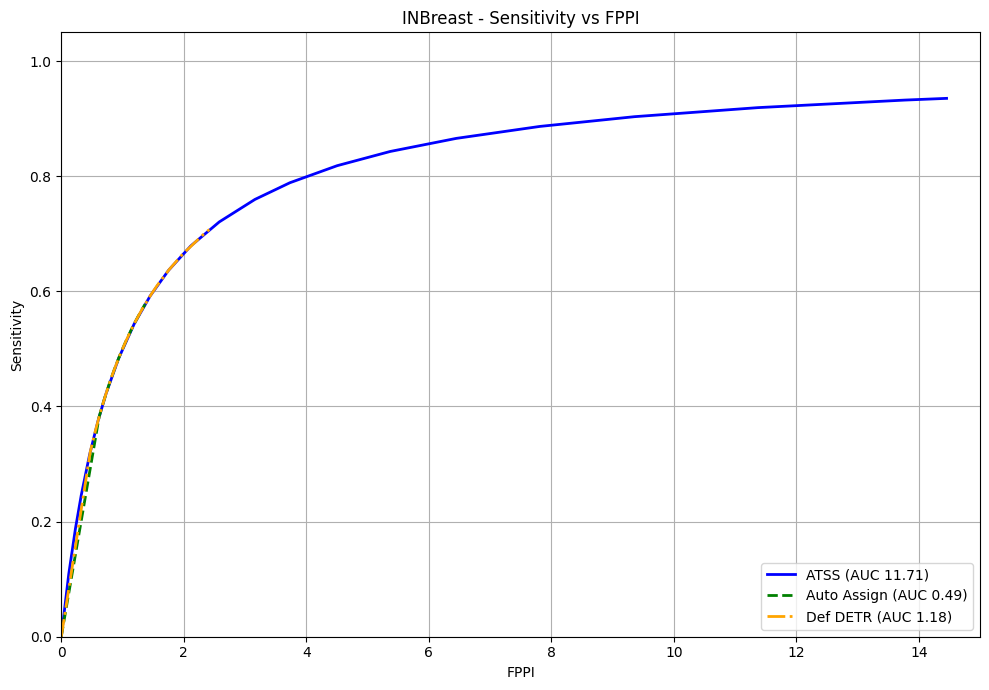

In [24]:
import matplotlib.pyplot as plt
import pickle
from sklearn.metrics import auc
import os

# === CONFIGURACIÓN ===
# Diccionario con nombres de modelo y rutas a archivos .pkl
pkl_paths = {
    "ATSS": "./results_model_NO_augm_NO_pretrained.pkl",
    "Auto Assign": "./results_model_NO_augm_SI_pretrained.pkl",
    "Def DETR": "./results_model_final_SI_augm_flipXY_SI_pretrained_NO_earlyStopping.pkl",
    # "DETR": "detr.pkl",
    # "Faster RCNN": "faster_rcnn.pkl",
    # "PAA": "paa.pkl",
    # "VFNet": "vfnet.pkl",
    # "YOLOF": "yolof.pkl"
}

# Estilos opcionales por modelo (colores y líneas)
styles = {
    "ATSS": ('blue', '-'),
    "Auto Assign": ('green', '--'),
    "Def DETR": ('orange', '-.'),
    # "DETR": ('red', '--'),
    # "Faster RCNN": ('magenta', '-'),
    # "PAA": ('brown', '--'),
    # "VFNet": ('cyan', '-.'),
    # "YOLOF": ('darkgreen', ':')
}

# === FUNCIÓN PRINCIPAL ===
def plot_curves_from_pkls(pkl_paths):
    plt.figure(figsize=(10, 7))

    for model_name, file_path in pkl_paths.items():
        # Cargar el .pkl
        with open(file_path, 'rb') as f:
            data = pickle.load(f)

        # Extraer pares (fppi, tpr)
        fppi = []
        tpr_aux = []
        tpr = []
        for threshold_data in data.values():
            fppi.append(threshold_data['fppi'])
            tpr_aux.append({threshold_data['tpr']: model_name})
            tpr.append(threshold_data['tpr'])

        print(tpr_aux, "\n")
        # print(tpr)
        # Ordenar por fppi para una curva bien definida
        sorted_pairs = sorted(zip(fppi, tpr))
        fppi_sorted, tpr_sorted = zip(*sorted_pairs)

        # Calcular AUC
        model_auc = auc(fppi_sorted, tpr_sorted)

        # Estilo de curva
        color, linestyle = styles.get(model_name, ('black', '-'))
        plt.plot(fppi_sorted, tpr_sorted, linestyle, color=color, label=f"{model_name} (AUC {model_auc:.2f})", linewidth=2)

    # Estética del gráfico
    plt.xlabel("FPPI")
    plt.ylabel("Sensitivity")
    plt.title("INBreast - Sensitivity vs FPPI")
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.xlim([0.0, 15.0])  # Ajustable según rango de fppi
    plt.ylim([0.0, 1.05])
    plt.tight_layout()
    plt.savefig("tpr_vs_fppi_999999999.png", dpi=300, bbox_inches='tight')


# === LLAMADA A LA FUNCIÓN ===
plot_curves_from_pkls(pkl_paths)


In [5]:
# Eliminar segmentation

import json

def remove_field_from_coco(coco_file_path, output_file_path, field_to_remove='segmentation'):
    """
    Elimina un campo específico de las anotaciones en un archivo COCO JSON.
    
    Args:
        coco_file_path (str): Ruta al archivo COCO JSON original
        output_file_path (str): Ruta donde guardar el archivo modificado
        field_to_remove (str): Campo a eliminar (por defecto 'segmentation')
    """
    try:
        # Leer el archivo COCO
        with open(coco_file_path, 'r') as f:
            coco_data = json.load(f)
        
        # Eliminar el campo de cada anotación
        if 'annotations' in coco_data:
            for annotation in coco_data['annotations']:
                if field_to_remove in annotation:
                    del annotation[field_to_remove]
        
        # Guardar el archivo modificado
        with open(output_file_path, 'w') as f:
            json.dump(coco_data, f, indent=4)
            
        print(f"Campo '{field_to_remove}' eliminado correctamente. Archivo guardado en: {output_file_path}")
    
    except Exception as e:
        print(f"Error: {str(e)}")

# Ejemplo de uso
if __name__ == "__main__":
    input_file = "./coco/annotations/instances_coco_mass_val.json"  # Cambiar por tu archivo de entrada
    output_file = "./coco/annotations/instances_coco_mass_val_no_segmentation.json"  # Archivo de salida
    
    remove_field_from_coco(input_file, output_file, 'segmentation')

Campo 'segmentation' eliminado correctamente. Archivo guardado en: ./coco/annotations/instances_coco_mass_val_no_segmentation.json


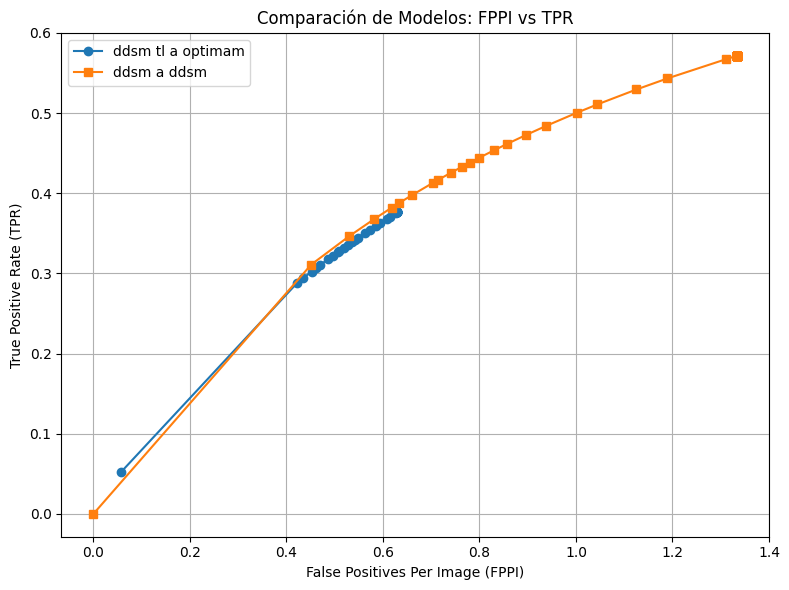

In [12]:
# pruebas

import matplotlib.pyplot as plt

# comparamos ddsm tl a optimam
# ddsm a ddsm

# Listas de ejemplo para modelo 1
fppiValues_model1 = [0.6299879081015719, 0.6299879081015719, 0.6299879081015719, 0.6299879081015719, 0.6299879081015719, 0.6299879081015719, 0.6299879081015719, 0.6299879081015719, 0.6299879081015719, 0.6299879081015719, 0.6299879081015719, 0.6299879081015719, 0.6299879081015719, 0.6299879081015719, 0.6299879081015719, 0.6299879081015719, 0.6299879081015719, 0.6299879081015719, 0.6299879081015719, 0.6299879081015719, 0.6299879081015719, 0.6299879081015719, 0.6299879081015719, 0.6299879081015719, 0.6299879081015719, 0.6299879081015719, 0.6299879081015719, 0.6299879081015719, 0.6275695284159613, 0.6154776299879081, 0.6082224909310762, 0.5937122128174124, 0.585247883917775, 0.5731559854897219, 0.562273276904474, 0.5489721886336155, 0.5429262394195888, 0.535671100362757, 0.5272067714631197, 0.5187424425634825, 0.5090689238210399, 0.5066505441354293, 0.4957678355501814, 0.4860943168077388, 0.46916565900846435, 0.4619105199516324, 0.45223700120918986, 0.43530834340991537, 0.42200725513905685, 0.05804111245465538]
tprValues_model1 = [0.3764450867052023, 0.3764450867052023, 0.3764450867052023, 0.3764450867052023, 0.3764450867052023, 0.3764450867052023, 0.3764450867052023, 0.3764450867052023, 0.3764450867052023, 0.3764450867052023, 0.3764450867052023, 0.3764450867052023, 0.3764450867052023, 0.3764450867052023, 0.3764450867052023, 0.3764450867052023, 0.3764450867052023, 0.3764450867052023, 0.3764450867052023, 0.3764450867052023, 0.3764450867052023, 0.3764450867052023, 0.3764450867052023, 0.3764450867052023, 0.3764450867052023, 0.3764450867052023, 0.3764450867052023, 0.3764450867052023, 0.3755426917510854, 0.37099125364431484, 0.36822840409956076, 0.362629246676514, 0.3593170007423905, 0.3545250560957367, 0.3501506024096386, 0.3447228549734245, 0.34222560975609756, 0.3392036753445635, 0.33564280215550424, 0.3320433436532508, 0.3278816199376947, 0.32683307332293293, 0.3220738413197172, 0.31778656126482213, 0.3101518784972022, 0.3068273092369478, 0.30234438156831045, 0.294358135731807, 0.28795379537953797, 0.052689352360043906]


# Listas de ejemplo para modelo 2
fppiValues_model2 = [1.3342618384401115, 1.3342618384401115, 1.3342618384401115, 1.3342618384401115, 1.3342618384401115, 1.3342618384401115, 1.3342618384401115, 1.3342618384401115, 1.3342618384401115, 1.3342618384401115, 1.3342618384401115, 1.3342618384401115, 1.3342618384401115, 1.3342618384401115, 1.3342618384401115, 1.3342618384401115, 1.3342618384401115, 1.3342618384401115, 1.3342618384401115, 1.3342618384401115, 1.3342618384401115, 1.3342618384401115, 1.3342618384401115, 1.3342618384401115, 1.3342618384401115, 1.3342618384401115, 1.3342618384401115, 1.3342618384401115, 1.3119777158774373, 1.1894150417827298, 1.1253481894150419, 1.0445682451253482, 1.0027855153203342, 0.9387186629526463, 0.8969359331476323, 0.8579387186629527, 0.83008356545961, 0.7994428969359332, 0.7799442896935933, 0.7632311977715878, 0.7409470752089137, 0.713091922005571, 0.7047353760445683, 0.6601671309192201, 0.6323119777158774, 0.6183844011142061, 0.5821727019498607, 0.5292479108635098, 0.45125348189415043, 0.0]
tprValues_model2 = [0.5715990453460621, 0.5715990453460621, 0.5715990453460621, 0.5715990453460621, 0.5715990453460621, 0.5715990453460621, 0.5715990453460621, 0.5715990453460621, 0.5715990453460621, 0.5715990453460621, 0.5715990453460621, 0.5715990453460621, 0.5715990453460621, 0.5715990453460621, 0.5715990453460621, 0.5715990453460621, 0.5715990453460621, 0.5715990453460621, 0.5715990453460621, 0.5715990453460621, 0.5715990453460621, 0.5715990453460621, 0.5715990453460621, 0.5715990453460621, 0.5715990453460621, 0.5715990453460621, 0.5715990453460621, 0.5715990453460621, 0.5674698795180723, 0.5432569974554707, 0.5294888597640891, 0.510899182561308, 0.5006954102920723, 0.48419540229885055, 0.47283406754772395, 0.4617691154422789, 0.4535768645357686, 0.44427244582043346, 0.4381846635367762, 0.43285939968404424, 0.4256, 0.416260162601626, 0.4133986928104575, 0.3976510067114094, 0.3873720136518771, 0.38209982788296043, 0.36795774647887325, 0.3460837887067395, 0.31094049904030713, 0.0]

plt.figure(figsize=(8, 6))
plt.plot(fppiValues_model1, tprValues_model1, marker='o', label='ddsm tl a optimam')
plt.plot(fppiValues_model2, tprValues_model2, marker='s', label='ddsm a ddsm')

# Añadir anotaciones para Modelo 1
# print("Valores modelo 1: \n")
# for x, y in zip(fppiValues_model1, tprValues_model1):
#     print(f'({x:.2f}, {y:.2f})')
#     plt.text(x, y, f'({x:.2f}, {y:.2f})', fontsize=9, ha='right', va='bottom', color='blue')

# print("Valores modelo 2: \n")
# # Añadir anotaciones para Modelo 2
# for x, y in zip(fppiValues_model2, tprValues_model2):
#     print(f'({x:.2f}, {y:.2f})')
#     plt.text(x, y, f'({x:.2f}, {y:.2f})', fontsize=9, ha='left', va='top', color='green')

plt.xlabel('False Positives Per Image (FPPI)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('Comparación de Modelos: FPPI vs TPR')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

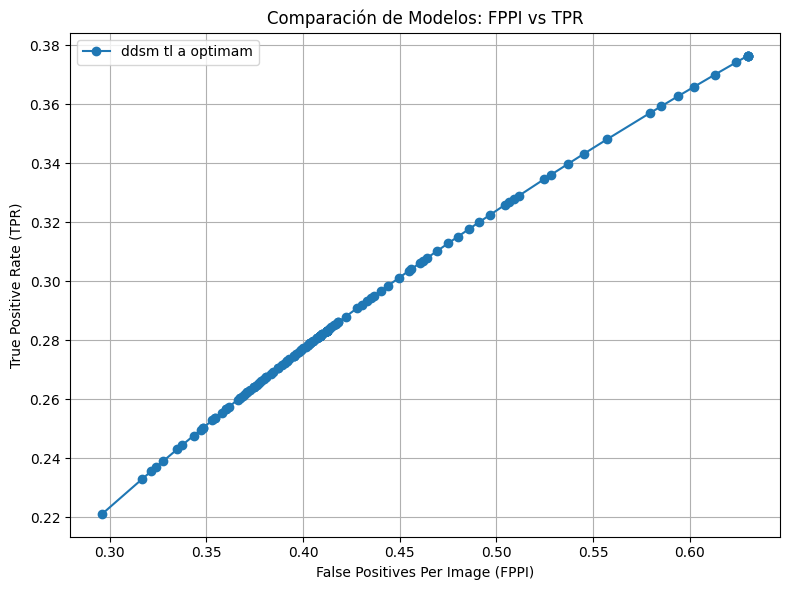

In [2]:
import matplotlib.pyplot as plt

fppiValues = [0.6299879081015719, 0.6299879081015719, 0.6299879081015719, 0.6299879081015719, 0.6299879081015719, 0.6239419588875453, 0.6130592503022975, 0.6021765417170496, 0.5937122128174124, 0.585247883917775, 0.5792019347037485, 0.5574365175332527, 0.5453446191051995, 0.5368802902055623, 0.528415961305925, 0.524788391777509, 0.5114873035066505, 0.5090689238210399, 0.5066505441354293, 0.5042321644498187, 0.4969770253929867, 0.4909310761789601, 0.4860943168077388, 0.4800483675937122, 0.4752116082224909, 0.46916565900846435, 0.46432889963724305, 0.4619105199516324, 0.4607013301088271, 0.4558645707376058, 0.4546553808948005, 0.4498186215235792, 0.4437726723095526, 0.44014510278113667, 0.4365175332527207, 0.43530834340991537, 0.4328899637243047, 0.43047158403869407, 0.4280532043530834, 0.42200725513905685, 0.4183796856106409, 0.4183796856106409, 0.41717049576783555, 0.4159613059250302, 0.4147521160822249, 0.4135429262394196, 0.41233373639661425, 0.41233373639661425, 0.41233373639661425, 0.41233373639661425, 0.41233373639661425, 0.41233373639661425, 0.41233373639661425, 0.41233373639661425, 0.41233373639661425, 0.41233373639661425, 0.41233373639661425, 0.41233373639661425, 0.41233373639661425, 0.41233373639661425, 0.41233373639661425, 0.40991535671100365, 0.40991535671100365, 0.40991535671100365, 0.40870616686819833, 0.40870616686819833, 0.40870616686819833, 0.40870616686819833, 0.40870616686819833, 0.40870616686819833, 0.40870616686819833, 0.40870616686819833, 0.40870616686819833, 0.40870616686819833, 0.407496977025393, 0.407496977025393, 0.407496977025393, 0.40507859733978235, 0.40507859733978235, 0.40386940749697703, 0.40386940749697703, 0.40386940749697703, 0.40386940749697703, 0.4026602176541717, 0.4026602176541717, 0.4026602176541717, 0.4014510278113664, 0.40024183796856105, 0.39903264812575573, 0.39903264812575573, 0.3978234582829504, 0.3966142684401451, 0.3954050785973398, 0.3954050785973398, 0.3954050785973398, 0.39298669891172916, 0.39177750906892383, 0.39177750906892383, 0.39177750906892383, 0.3905683192261185, 0.3893591293833132, 0.38694074969770254, 0.38694074969770254, 0.3845223700120919, 0.38331318016928656, 0.3808948004836759, 0.3808948004836759, 0.37968561064087064, 0.3784764207980653, 0.37726723095526, 0.37605804111245467, 0.37484885126964934, 0.37484885126964934, 0.37484885126964934, 0.3724304715840387, 0.37122128174123337, 0.37122128174123337, 0.37001209189842804, 0.3688029020556227, 0.3675937122128174, 0.3675937122128174, 0.36638452237001207, 0.3615477629987908, 0.3603385731559855, 0.3603385731559855, 0.35792019347037485, 0.3542926239419589, 0.3542926239419589, 0.35308343409915355, 0.3482466747279323, 0.3482466747279323, 0.347037484885127, 0.343409915356711, 0.3373639661426844, 0.3349455864570738, 0.32769044740024184, 0.32406287787182586, 0.3216444981862152, 0.31680773881499397, 0.2962515114873035]
tprValues = [0.3764450867052023, 0.3764450867052023, 0.3764450867052023, 0.3764450867052023, 0.3764450867052023, 0.3741841914430747, 0.3700729927007299, 0.36590742101396034, 0.362629246676514, 0.3593170007423905, 0.356929955290611, 0.34818731117824775, 0.3432267884322679, 0.33970925784238715, 0.33615384615384614, 0.3346183500385505, 0.32892690513219286, 0.3278816199376947, 0.32683307332293293, 0.32578125, 0.3226059654631083, 0.3199369582348306, 0.31778656126482213, 0.31507936507936507, 0.31289808917197454, 0.3101518784972022, 0.3079390537289495, 0.3068273092369478, 0.3062700964630225, 0.3040322580645161, 0.30347054075867635, 0.30121457489878545, 0.2983739837398374, 0.29665851670741644, 0.2949346405228758, 0.294358135731807, 0.2932022932022932, 0.29204265791632483, 0.2908792111750205, 0.28795379537953797, 0.28618693134822165, 0.28618693134822165, 0.2855960264900662, 0.28500414250207123, 0.28441127694859036, 0.2838174273858921, 0.28322259136212624, 0.28322259136212624, 0.28322259136212624, 0.28322259136212624, 0.28322259136212624, 0.28322259136212624, 0.28322259136212624, 0.28322259136212624, 0.28322259136212624, 0.28322259136212624, 0.28322259136212624, 0.28322259136212624, 0.28322259136212624, 0.28322259136212624, 0.28322259136212624, 0.2820299500831947, 0.2820299500831947, 0.2820299500831947, 0.28143213988343047, 0.28143213988343047, 0.28143213988343047, 0.28143213988343047, 0.28143213988343047, 0.28143213988343047, 0.28143213988343047, 0.28143213988343047, 0.28143213988343047, 0.28143213988343047, 0.2808333333333333, 0.2808333333333333, 0.2808333333333333, 0.27963272120200333, 0.27963272120200333, 0.27903091060985796, 0.27903091060985796, 0.27903091060985796, 0.27903091060985796, 0.27842809364548493, 0.27842809364548493, 0.27842809364548493, 0.2778242677824268, 0.27721943048576214, 0.2766135792120704, 0.2766135792120704, 0.276006711409396, 0.2753988245172124, 0.2747899159663866, 0.2747899159663866, 0.2747899159663866, 0.2735690235690236, 0.2729570345408593, 0.2729570345408593, 0.2729570345408593, 0.2723440134907251, 0.2717299578059072, 0.2704987320371936, 0.2704987320371936, 0.26926333615580017, 0.26864406779661015, 0.267402376910017, 0.267402376910017, 0.26677994902293967, 0.266156462585034, 0.265531914893617, 0.26490630323679726, 0.26427962489343565, 0.26427962489343565, 0.26427962489343565, 0.2630230572160547, 0.2623931623931624, 0.2623931623931624, 0.2617621899059025, 0.2611301369863014, 0.26049700085689803, 0.26049700085689803, 0.25986277873070324, 0.2573149741824441, 0.2566752799310939, 0.2566752799310939, 0.2553925798101812, 0.25346020761245674, 0.25346020761245674, 0.2528138528138528, 0.25021720243266726, 0.25021720243266726, 0.24956521739130436, 0.24760244115082825, 0.24430823117338005, 0.24298245614035088, 0.23897707231040563, 0.2369584438549956, 0.23560673162090345, 0.2328888888888889, 0.22111913357400723]

plt.figure(figsize=(8, 6))
plt.plot(fppiValues, tprValues, marker='o', label='ddsm tl a optimam')

plt.xlabel('False Positives Per Image (FPPI)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('Comparación de Modelos: FPPI vs TPR')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()